# Vizualization 

### Utility Methods

In [99]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import aquarel

import sys
from glob import glob
import json
from tqdm import tqdm
sys.path.append('../python/')
from result_analysis_utils import load_ground_truth_data, load_evaluations

def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

def get_distrib_data(data):
    df = []
    for topic in data:
        for distr in ["Uninformed", "Informed"]:
            tmp = pd.DataFrame()
            tmp['value'] = topic["distribution"][distr.lower()]
            tmp['distribution'] = distr
            tmp["topic"] = topic["topic"]
            df.append(tmp)
    return pd.concat(df)

def get_scalar_data(data):
    df = []
    for topic in data:
        tmp = topic["scalar"]
        tmp["topic"] = topic["topic"]
        df.append(tmp)
    return pd.DataFrame(df).reset_index().rename({"index": "topic_num"}, axis=1)

def create_plot(data):
    with (
        aquarel
        .load_theme("boxy_light")
        .set_axes(bottom=False, top=False, left=False, right=False, ymargin=0.1)
        .set_ticks(draw_minor=False)
        .set_color(grid_color="k", tick_color="k")
    ):
        fig, ax = plt.subplots(figsize=(10,5))
        sns.violinplot(
            ax=ax,
            data=get_distrib_data(data),
            x = "topic",
            y = "value",
            hue = "distribution",
            split=True,
            inner=None,
            linewidth=0,
            saturation=0.5,
            cut=0
        )
        for violin in zip(ax.collections):
            for face in violin:
                face.set_facecolor(to_rgba(face.get_facecolor(), alpha=0.9))

        total_topics = len(data)
        scalars = get_scalar_data(data)
        plt.ylim(0, 1)
        plt.scatter(
            scalars.loc[:, "topic_num"].values,
            scalars.loc[:, "condensed"].values,
            marker="x", color="k", label="Condensed", s=50,
            
        )
        plt.scatter(
            scalars.loc[:, "topic_num"].values,
            scalars.loc[:, "actual"].values,
            marker="o", color="k", label="Actual", s=50
        )

        plt.scatter(
            scalars.loc[:, "topic_num"].values,
            scalars.loc[:, "predicted"].values,
            marker="P", color="k", label="Predicted", s=50
        )
        
        for index, row in scalars.iterrows():
            plt.plot((index, index), (row["min_resid"], row["max_resid"]), marker=None, color="k", label="Residuals", linewidth=1)
            plt.plot((index - 0.1, index + 0.1), (row["min_resid"], row["min_resid"]), marker=None, color="k")
            plt.plot((index - 0.1, index + 0.1), (row["max_resid"], row["max_resid"]), marker=None, color="k")

        handles, _ = ax.get_legend_handles_labels()

        covered_handles = set()
        new_handles = []
        for handle in handles:
            if handle.get_label() not in covered_handles:
                new_handles += [handle]
                covered_handles.add(handle.get_label())

        plt.legend(handles=new_handles)
        ax.set_xlabel("Topic")
        ax.set_ylabel("nDCG@10")

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=6, title=None, frameon=False,
    )
    
    return plt

### Load data and produce plot

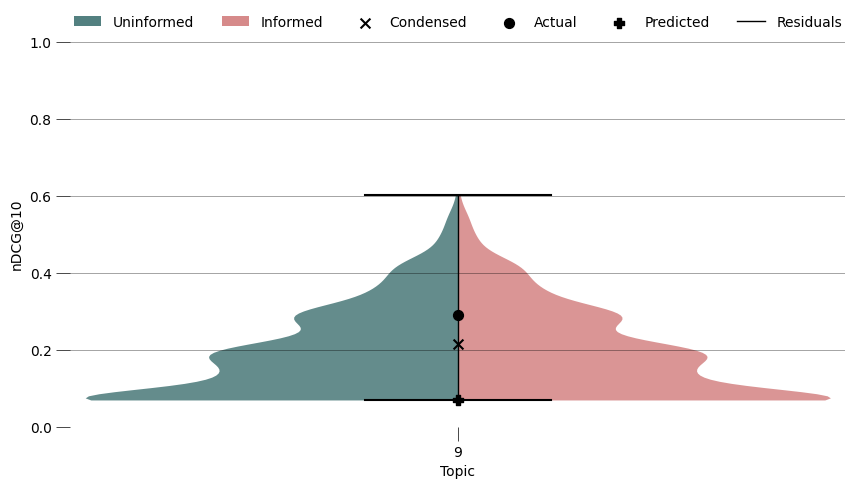

In [137]:
TOPICS = [9]

data = df_run[df_run['topic'].isin(TOPICS)].copy()
data = [i.to_dict() for _, i in data.iterrows()]

create_plot(data).show()

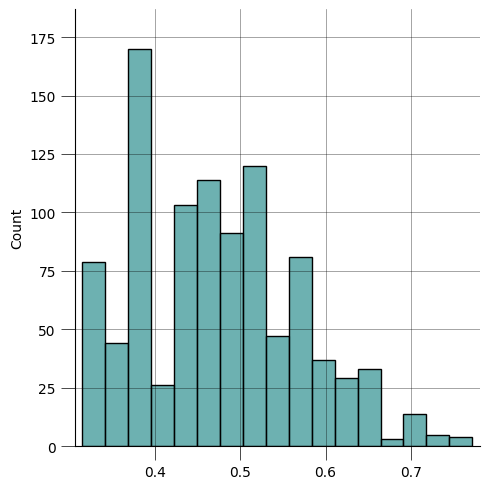

In [96]:
data = [json.loads(l) for l in open('beir-visualization-ance.jsonl')]

data = [i for i in data if i['topic'] == '19']
assert len(data) == 1
data = data[0]


sns.displot(data['distribution']['uninformed'])

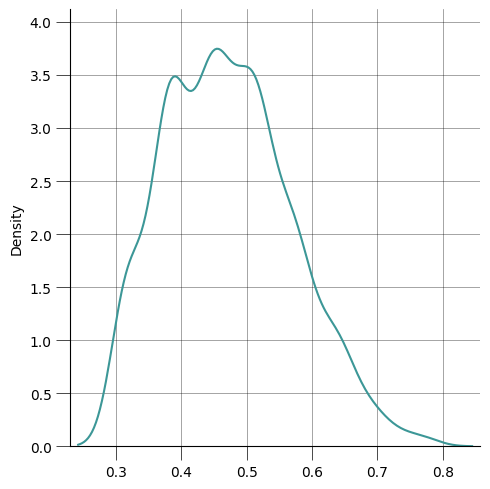

In [98]:
sns.displot(data['distribution']['uninformed'], kind='kde')

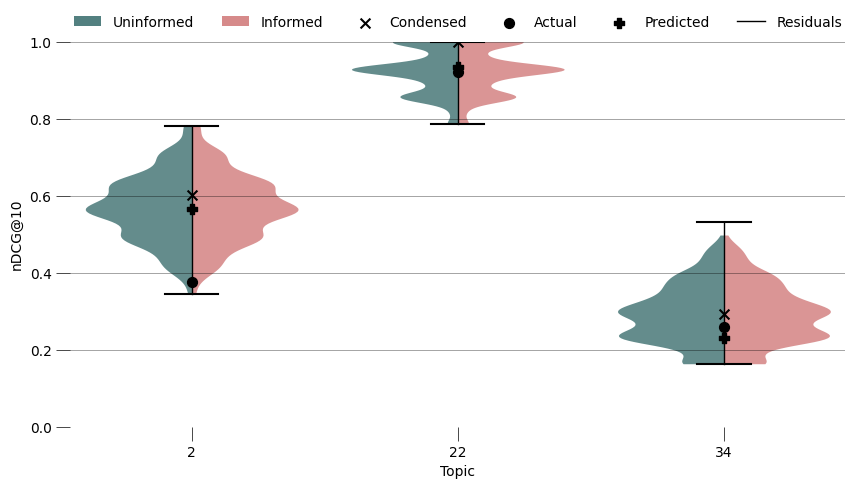

In [142]:
df_run = pd.read_json('beir-visualization-ance.jsonl', lines=True)
TOPICS = [2, 3, 12, 22, 19, 34, 17, 9]
TOPICS = [34, 22, 2]

data = df_run[df_run['topic'].isin(TOPICS)].copy()
data = [i.to_dict() for _, i in data.iterrows()]

my_plot = create_plot(data)
my_plot.savefig('plot-initial-example.pdf')
my_plot.show()

# Create Data

The following cells can be used to create the data that is used above for the plots

In [2]:
def flatten_row(df_row, measure, bootstrap, failsave):
    ret = []
    informed_bootstrapping = BootstrappingInducedByCondensedLists(0.75, 'm')

    try:
        depth = int(measure.split('@')[-1])
        actual = json.loads(df_row[(f'depth-{depth}-complete', measure)])
        unjudged = json.loads(df_row[(f'depth-{depth}-incomplete', f'unjudged@{depth}')])
        condensed = json.loads(df_row[(f'depth-{depth}-incomplete', f'condensed-{measure}')])
        residual_min = json.loads(df_row[(f'depth-{depth}-incomplete', f'residual-{measure}-min')])
        residual_max = json.loads(df_row[(f'depth-{depth}-incomplete', f'residual-{measure}-max')])
        uninformed_distribution = json.loads(df_row[(f'depth-{depth}-incomplete',bootstrap)])

        for topic in actual.keys():
            ret += [{
                'topic': topic,
                'run': df_row['run'],
                'measure': measure,
                'scalar': {
                    'min_resid': residual_min[topic],
                    'max_resid': residual_max[topic],
                    'actual': actual[topic],
                    'condensed': condensed[topic],
                    'predicted': select_element(uninformed_distribution[topic])
                },
                'distribution': {
                    "uninformed": uninformed_distribution[topic],
                    "informed": uninformed_distribution[topic], #informed_bootstrapping.adjust_to_target(uninformed_distribution[topic], condensed[topic]),
                },
                'unjudged': unjudged[topic],
                'p_normaltest': normaltest(uninformed_distribution[topic])
            }]
    except Exception as e:
        if not failsave:
            raise e

    return ret

def load_data(trec, measure, bootstrap_type, working_dir = '../resources/eval', failsave=False):
    ret = []
    for _, i in load_evaluations(tqdm(glob(working_dir + '/trec-system-runs/' + trec + '/*.jsonl'))).iterrows():
        ret += flatten_row(i, measure, bootstrap_type, failsave)
        
    return pd.DataFrame(ret)


In [6]:
def load_beir_bootstrapping_results_and_group_by_xy():
    from trectools import TrecRun, TrecQrel, TrecEval
    qrels_complete = TrecQrel('../resources/unprocessed/topics-and-qrels/qrels.trec-covid-complete.txt')
    qrels_with_unjudged = TrecQrel('../resources/unprocessed/topics-and-qrels/qrels.trec-covid-incomplete.txt')
    tmp = json.load(open('beir-bootstrapping-results.jsonl', 'r'))
    ret = {}
    
    for eval_run in tmp:
        eval_run = eval_run['depth-10-incomplete']
        for eval_topic in eval_run:
            measures = [i for i in eval_topic.keys() if i not in ['run_file', 'query']]

            if eval_topic['run_file'] not in ret:
                ret[eval_topic['run_file']] = {}

            if eval_topic['query'] not in ret[eval_topic['run_file']]:
                ret[eval_topic['run_file']][eval_topic['query']] = {}

            for measure in measures:
                if measure in ret[eval_topic['run_file']][eval_topic['query']]:
                    raise ValueError('assasa')

                ret[eval_topic['run_file']][eval_topic['query']][measure] = eval_topic[measure]
    
    for run_name in ret.keys():
        run = TrecRun(run_name)
        te = TrecEval(run, qrels_complete).get_ndcg(depth=10, per_query=True)
        te_condensed = TrecEval(run, qrels_with_unjudged).get_ndcg(depth=10, removeUnjudged=True, per_query=True)
        
        for _, i in te.iterrows():
            ret[run_name][i.name]['actual-ndcg@10'] = i['NDCG@10']

        for _, i in te_condensed.iterrows():
            ret[run_name][i.name]['condensed-ndcg@10'] = i['NDCG@10']
        
        te_condensed = TrecEval(run, qrels_with_unjudged).get_unjudged(depth=10, per_query=True)
        
        
        for _, i in te_condensed.iterrows():
            ret[run_name][i.name]['unjudged@10'] = i['UNJ@10']
        
        
    return ret

def flatten_row(run_name, failsave=False):
    from parametrized_bootstrapping_model import BootstrappingBySelectingMostLikelyDataPoint, FixedQuantileBootstrappingModel, BootstrappingInducedByCondensedLists
    ret = []
    data = load_beir_bootstrapping_results_and_group_by_xy()[run_name]
    informed_bootstrapping = BootstrappingInducedByCondensedLists(0.95, 'm')

    model = BootstrappingBySelectingMostLikelyDataPoint('unimportant')
    
    try:
        for topic in data.keys():
            prediction = model.predict([data[topic]['ndcg@10']])
            assert len(prediction) == 1
            ret += [{
                'topic': topic,
                'run': run_name.split('/')[-1].split('-run')[0],
                'measure': 'ndcg@10',
                'scalar': {
                    'min_resid': data[topic]['MIN-NDCG@10'],
                    'max_resid': data[topic]['MAX-NDCG@10'],
                    'actual': data[topic]['actual-ndcg@10'],
                    'condensed': data[topic]['condensed-ndcg@10'],
                    'predicted': prediction[0]
                },
                'distribution': {
                    "uninformed": data[topic]['ndcg@10'],
                    "informed": data[topic]['ndcg@10'],
                },
                'unjudged': data[topic]['unjudged@10'],
            }]
    except Exception as e:
        if not failsave:
            raise e

    return ret

tmp = load_beir_bootstrapping_results_and_group_by_xy()

In [7]:
df_beir_visualization = pd.DataFrame(flatten_row('../resources/processed/normalized-runs/trec-system-runs/trec-covid/ance-run.txt'))

# focus on some interesting points
df_beir_visualization = df_beir_visualization[(df_beir_visualization['unjudged'] > 0.2) & (df_beir_visualization['unjudged'] < 0.8)]
df_beir_visualization.to_json('beir-visualization-ance.jsonl', lines=True, orient='records')
df_beir_visualization

,topic,run,measure,scalar,distribution,unjudged
2,11,ance,ndcg@10,"{'min_resid': nan, 'max_resid': 0.472893503359...","{'uninformed': [0.0, 0.03181039409947586, 0.0,...",0.6
3,12,ance,ndcg@10,"{'min_resid': 0.39556758257317387, 'max_resid'...","{'uninformed': [0.6032079661175445, 0.71325384...",0.3
4,13,ance,ndcg@10,"{'min_resid': 0.47095699092922244, 'max_resid'...","{'uninformed': [0.7144327350540887, 0.75418950...",0.6
8,17,ance,ndcg@10,"{'min_resid': 0.6146216729884262, 'max_resid':...","{'uninformed': [0.7711623626481158, 0.80981067...",0.4
10,19,ance,ndcg@10,"{'min_resid': 0.31488013066763093, 'max_resid'...","{'uninformed': [0.424926013816671, 0.393278399...",0.5
11,2,ance,ndcg@10,"{'min_resid': 0.3436966913921454, 'max_resid':...","{'uninformed': [0.4735717030454861, 0.55778040...",0.6
14,22,ance,ndcg@10,"{'min_resid': 0.7859162856301584, 'max_resid':...","{'uninformed': [0.8521705090845474, 0.96687288...",0.3
21,29,ance,ndcg@10,"{'min_resid': 0.38662645599115164, 'max_resid'...","{'uninformed': [0.6722167440634262, 0.60278552...",0.4
22,3,ance,ndcg@10,"{'min_resid': 0.3628869103342175, 'max_resid':...","{'uninformed': [0.558645109126546, 0.637152379...",0.6
25,32,ance,ndcg@10,"{'min_resid': 0.22009176629808017, 'max_resid'...","{'uninformed': [0.22009176629808017, 0.2837125...",0.4


In [212]:
df_run = load_data('trec22', 'ndcg@10', 'bs-run-dependent-1000-ndcg@10-ndcg@10', '../resources/eval')
df_pool = load_data('trec22', 'ndcg@10', 'bs-pool-dependent-1000-ndcg@10-ndcg@10', '../resources/eval')
df_run_and_pool = load_data('trec22', 'ndcg@10', 'bs-run-and-pool-dependent-1000-ndcg@10-ndcg@10', '../resources/eval')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:03<00:00, 69.61it/s]
/mnt/ceph/storage/data-tmp/current/kibi9872/ecir23-incomplete-judgments/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1667: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/mnt/ceph/storage/data-tmp/current/kibi9872/ecir23-incomplete-judgments/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1771: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:03<00:00, 69.80it/s]


The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rej

/mnt/ceph/storage/data-tmp/current/kibi9872/ecir23-incomplete-judgments/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1667: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/mnt/ceph/storage/data-tmp/current/kibi9872/ecir23-incomplete-judgments/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1771: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rej

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:03<00:00, 68.58it/s]
/mnt/ceph/storage/data-tmp/current/kibi9872/ecir23-incomplete-judgments/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1667: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/mnt/ceph/storage/data-tmp/current/kibi9872/ecir23-incomplete-judgments/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1771: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


The null hypothesis that x comes from a normal distribution cannot be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null hypothesis that x comes from a normal distribution can be rejected
The null 

In [215]:
df_run_and_pool[(df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.7) & (df_run_and_pool['p_normaltest'] > 0.001)]


,topic,run,measure,scalar,distribution,unjudged,p_normaltest
14,216,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.12630812196576116, 'max_resid'...","{'uninformed': [0.35332125057226593, 0.4706651...",0.6,0.007432
34,236,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.5242072506592408, 'max_resid':...","{'uninformed': [0.5868606623815296, 0.64951407...",0.3,0.018969
61,214,ICTNET13ADR2,ndcg@10,"{'min_resid': 0.2619647490790787, 'max_resid':...","{'uninformed': [0.5144082803622572, 0.44497705...",0.5,0.015386
110,214,ICTNET13ADR3,ndcg@10,"{'min_resid': 0.4263166231195256, 'max_resid':...","{'uninformed': [0.5973673119326534, 0.53733159...",0.5,0.037283
132,236,ICTNET13ADR3,ndcg@10,"{'min_resid': 0.5242072506592408, 'max_resid':...","{'uninformed': [0.5242072506592409, 0.73585996...",0.3,0.119397
...,...,...,...,...,...,...,...
1437,218,webisrandom,ndcg@10,"{'min_resid': 0.31071828981082744, 'max_resid'...","{'uninformed': [0.44045178719567174, 0.5564412...",0.5,0.006171
1489,221,webiswtbaseline,ndcg@10,"{'min_resid': 0.22316172763532005, 'max_resid'...","{'uninformed': [0.31840027658813985, 0.2633440...",0.5,0.001202
1531,214,wistud.runA,ndcg@10,"{'min_resid': 0.181762909948223, 'max_resid': ...","{'uninformed': [0.21647852091661166, 0.2243344...",0.4,0.001507
1621,206,wistud.runC,ndcg@10,"{'min_resid': 0.2901559813348286, 'max_resid':...","{'uninformed': [0.4982588489737789, 0.53608015...",0.6,0.066047


In [217]:
df_run_and_pool[(df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.7) & (df_run_and_pool['p_normaltest'] <= 0.001)]


,topic,run,measure,scalar,distribution,unjudged,p_normaltest
1,203,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.16732663612414972, 'max_resid'...","{'uninformed': [0.16732663612414972, 0.2136141...",0.1,1.505451e-60
2,204,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.10096983442277767, 'max_resid'...","{'uninformed': [0.1926747370469777, 0.10096983...",0.5,7.065115e-13
3,205,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.39951935196778005, 'max_resid'...","{'uninformed': [0.43367485557705404, 0.4572488...",0.2,5.985863e-13
5,207,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.24401798544040257, 'max_resid'...","{'uninformed': [0.36799043130578374, 0.3727271...",0.3,5.784386e-17
6,208,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.10909756388867499, 'max_resid'...","{'uninformed': [0.15649174607345037, 0.2263008...",0.3,1.567636e-12
...,...,...,...,...,...,...,...
1647,232,wistud.runC,ndcg@10,"{'min_resid': 0.11004588314904008, 'max_resid'...","{'uninformed': [0.18340980524840012, 0.1100458...",0.4,1.432272e-10
1651,236,wistud.runC,ndcg@10,"{'min_resid': 0.16773064167406343, 'max_resid'...","{'uninformed': [0.480416684100028, 0.284297595...",0.6,7.764386e-04
1660,245,wistud.runC,ndcg@10,"{'min_resid': 0.23230604393401819, 'max_resid'...","{'uninformed': [0.3150551263919474, 0.37967247...",0.5,3.063194e-11
1661,246,wistud.runC,ndcg@10,"{'min_resid': 0.08890681327238403, 'max_resid'...","{'uninformed': [0.2793863289907654, 0.18230018...",0.6,5.855984e-14


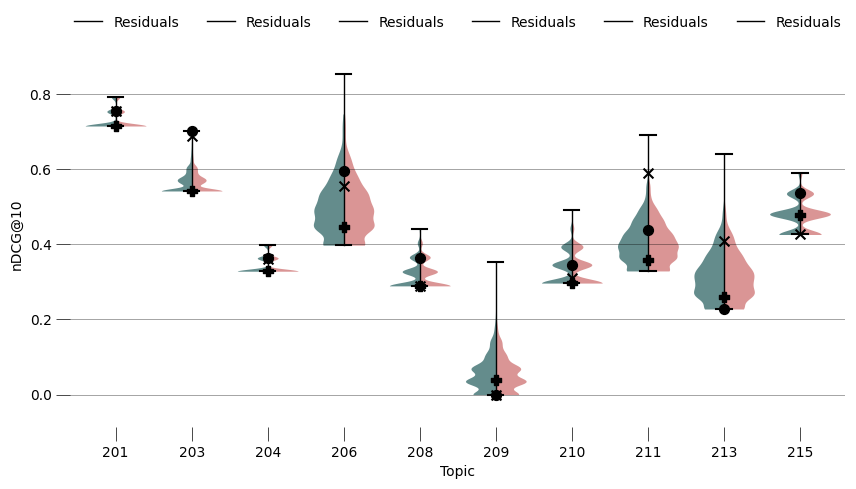

In [152]:
data = df_run[(df_run['run'] == 'clustmrfaf') & (df_run['unjudged'] > 0) & (df_run['unjudged'] < 0.6)].head(10).copy()
data = [i.to_dict() for _, i in data.iterrows()]

create_plot(data).show()

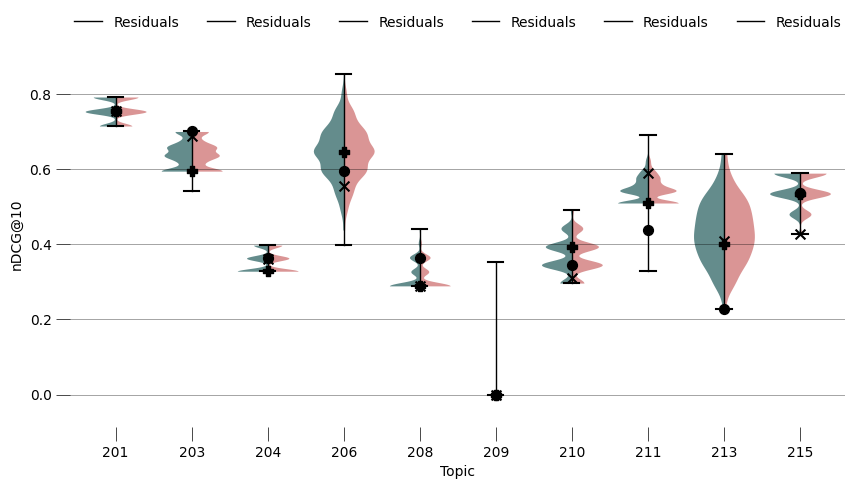

In [153]:
data = df_pool[(df_pool['run'] == 'clustmrfaf') & (df_pool['unjudged'] > 0) & (df_pool['unjudged'] < 0.6)].head(10).copy()
data = [i.to_dict() for _, i in data.iterrows()]

create_plot(data).show()

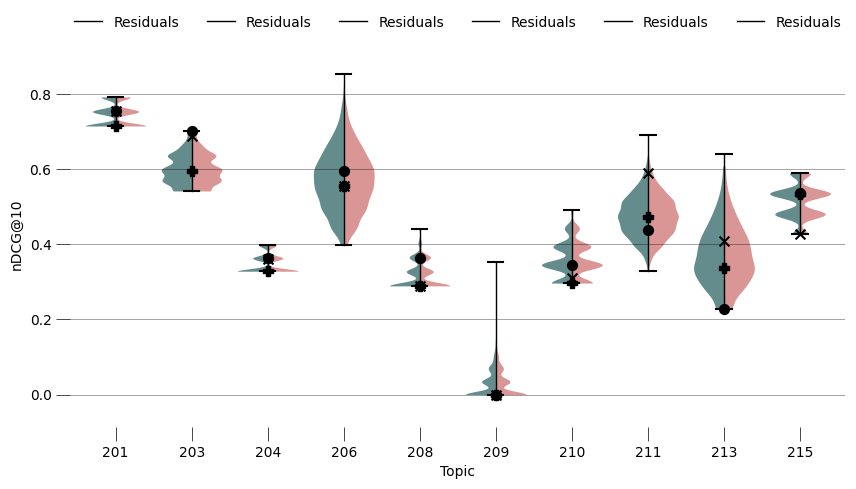

In [155]:
data = df_run_and_pool[(df_run_and_pool['run'] == 'clustmrfaf') & (df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.6)].head(10).copy()
data = [i.to_dict() for _, i in data.iterrows()]

create_plot(data).show()

In [157]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, np.maximum(y_pred, y), squared=False)

In [160]:
y = list(df_run_and_pool[(df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['actual']))

y_pred = list(df_run_and_pool[(df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['predicted']))

mean_squared_error(y, y_pred, squared=False)


0.07820010403510771

In [161]:
y = list(df_run_and_pool[(df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['actual']))

y_pred = list(df_run_and_pool[(df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['condensed']))

mean_squared_error(y, y_pred, squared=False)


0.08609589580680381

In [162]:
y = list(df_run[(df_run['unjudged'] > 0) & (df_run['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['actual']))

y_pred = list(df_run[(df_run['unjudged'] > 0) & (df_run['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['predicted']))

mean_squared_error(y, y_pred, squared=False)


0.0984187179385177

In [164]:
y = list(df_pool[(df_pool['unjudged'] > 0) & (df_pool['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['actual']))

y_pred = list(df_pool[(df_pool['unjudged'] > 0) & (df_pool['unjudged'] < 0.6)]['scalar'].apply(lambda i: i['predicted']))

mean_squared_error(y, y_pred, squared=False)


0.09573697707663045

In [156]:
df_run_and_pool[(df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.6)]


,topic,run,measure,scalar,distribution,unjudged
1,203,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.16732663612414972, 'max_resid'...","{'uninformed': [0.16732663612414972, 0.2136141...",0.1
2,204,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.10096983442277767, 'max_resid'...","{'uninformed': [0.1926747370469777, 0.10096983...",0.5
3,205,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.39951935196778005, 'max_resid'...","{'uninformed': [0.43367485557705404, 0.4572488...",0.2
5,207,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.24401798544040257, 'max_resid'...","{'uninformed': [0.36799043130578374, 0.3727271...",0.3
6,208,ICTNET13ADR1,ndcg@10,"{'min_resid': 0.10909756388867499, 'max_resid'...","{'uninformed': [0.15649174607345037, 0.2263008...",0.3
...,...,...,...,...,...,...
1637,222,wistud.runC,ndcg@10,"{'min_resid': 0.3014187709334496, 'max_resid':...","{'uninformed': [0.3486938707782575, 0.40567445...",0.4
1638,223,wistud.runC,ndcg@10,"{'min_resid': 0.0792111673228049, 'max_resid':...","{'uninformed': [0.13615783991403613, 0.1501477...",0.5
1643,228,wistud.runC,ndcg@10,"{'min_resid': 0.2317919975568828, 'max_resid':...","{'uninformed': [0.2625154453228204, 0.23179199...",0.1
1647,232,wistud.runC,ndcg@10,"{'min_resid': 0.11004588314904008, 'max_resid'...","{'uninformed': [0.18340980524840012, 0.1100458...",0.4


ValueError: Unrecognized marker style '-'

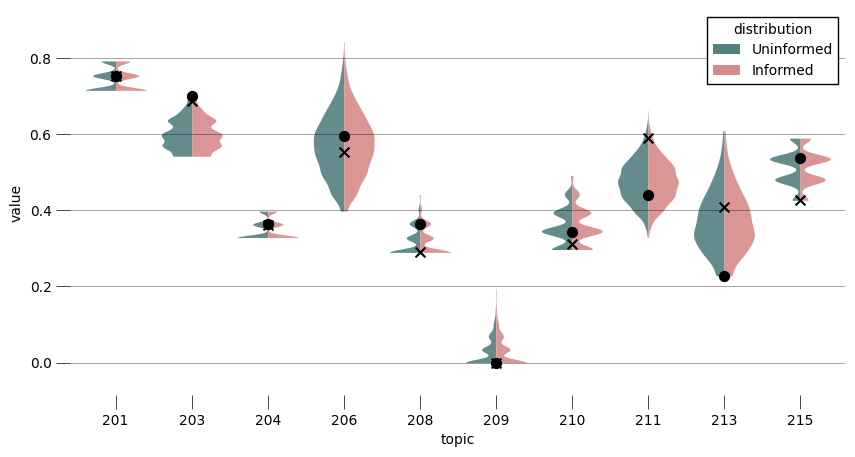

In [142]:
data = df_run_and_pool[(df_run_and_pool['run'] == 'clustmrfaf') & (df_run_and_pool['unjudged'] > 0) & (df_run_and_pool['unjudged'] < 0.6)].head(10).copy()
data = [i.to_dict() for _, i in data.iterrows()]

create_plot(data).show()

In [139]:
def select_element(data_points):
    cluster = cluster_datapoints(data_points)
    cluster = select_max_cluster(cluster)
    data_points = []
    for v in cluster.values():
        data_points += v

    cluster = cluster_datapoints(data_points)
    cluster = select_max_cluster(cluster)
    data_points = []
    for v in cluster.values():
        data_points += list(v)

    return max(data_points)


def cluster_datapoints(data_points):
    min_x = min(data_points)
    max_x = max(data_points)
    if (max_x-min_x) <= 0.0001:
        return {0: data_points}
    normalized_data_points = [(i-min_x)/(max_x-min_x) for i in data_points]
    clusters = {}

    for i in range(len(data_points)):
        
        normalized_data_point = normalized_data_points[i]
        data_point = data_points[i]
        for cluster in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
            if normalized_data_point <= cluster:
                if cluster not in clusters:
                    clusters[cluster] = []
                clusters[cluster] += [data_point]
                break

            if cluster >= 1:
                raise ValueError('Can not happen: It should be aleady asigned to a cluster. ' +
                             f'But element {normalized_data_point} did not found a cluster.')

    return clusters


def select_max_cluster(clusters):
    max_elements = max([len(i) for i in clusters.values()])

    ret = {}
    for k, v in clusters.items():
        if len(v) < max_elements:
            continue
        ret[k] = v

    return ret





In [127]:
select_element(data[-1]['distribution']['uninformed'])

0.5353612354376558

In [37]:
df_tmp = df_run.copy()
df_tmp = df_tmp[df_tmp['topic'] == '213']
df_tmp['ndcg@10'] = df_tmp['scalar'].apply(lambda i: i['actual'])
df_tmp.sort_values('ndcg@10')

,topic,run,measure,scalar,distribution,unjudged,ndcg@10
1481,213,webiswtbaseline,ndcg@10,"{'min_resid': 0, 'max_resid': 0.14782949091545...","{'uninformed': [0.039199134489337664, 0.034715...",0.2,0.000000
1383,213,webismixed,ndcg@10,"{'min_resid': 0, 'max_resid': 0.14782949091545...","{'uninformed': [0.0, 0.0, 0.039199134489337664...",0.2,0.000000
599,213,dlde,ndcg@10,"{'min_resid': 0, 'max_resid': 1.0, 'actual': 0...","{'uninformed': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.000000
1089,213,uogTrAIwLmb,ndcg@10,"{'min_resid': 0, 'max_resid': 1.0, 'actual': 0...","{'uninformed': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.047394
844,213,udelPseudo1,ndcg@10,"{'min_resid': 0.28838205139432177, 'max_resid'...","{'uninformed': [0.3578132733310991, 0.28838205...",0.3,0.047394
158,213,UDInfolabWEB1,ndcg@10,"{'min_resid': 0, 'max_resid': 0.39138176112557...","{'uninformed': [0.08514311764162098, 0.0851431...",0.5,0.063621
991,213,udemQlm1lFb,ndcg@10,"{'min_resid': 0.06362078819895171, 'max_resid'...","{'uninformed': [0.06362078819895171, 0.1061923...",0.1,0.063621
109,213,ICTNET13ADR3,ndcg@10,"{'min_resid': 0, 'max_resid': 0.75296940655264...","{'uninformed': [0.06784272269558314, 0.2172607...",0.7,0.069431
1432,213,webisrandom,ndcg@10,"{'min_resid': 0.06943122193677727, 'max_resid'...","{'uninformed': [0.14175746815330945, 0.1356854...",0.3,0.069431
550,213,cwiwt13kld,ndcg@10,"{'min_resid': 0.033127111727194514, 'max_resid...","{'uninformed': [0.033127111727194514, 0.088150...",0.2,0.088150


In [198]:
def normaltest(x, alpha = 1e-3):
    from scipy import stats
    _, p = stats.normaltest(x)
    
    if p < alpha:
        print('The null hypothesis that x comes from a normal distribution can be rejected')
    else:
        print("The null hypothesis that x comes from a normal distribution cannot be rejected")

    return p


In [200]:
normaltest(np.concatenate((rng.normal(0, 1, size=1000), rng.normal(2, 1, size=1000))))

The null hypothesis that x comes from a normal distribution can be rejected


2.378292692420543e-08

In [202]:
normaltest(rng.normal(0, 1, size=1000))

The null hypothesis that x comes from a normal distribution cannot be rejected


0.5451922504527603

In [203]:
normaltest(rng.normal(1, 10, size=1000))

The null hypothesis that x comes from a normal distribution cannot be rejected


0.18351528683961404

In [205]:
normaltest(rng.poisson(1, size=1000))

The null hypothesis that x comes from a normal distribution can be rejected


4.202184404441464e-34

In [207]:
normaltest(np.concatenate((rng.poisson(1, size=1000), rng.poisson(3, size=1000))))

The null hypothesis that x comes from a normal distribution can be rejected


1.311903366472367e-55